In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from torchvision import models

from matplotlib import pyplot as plt
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from PIL import Image
import os
import cv2
import numpy as np

/Users/vince/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
data_dar = "../data/amazon"

In [4]:
train = Path(data_dar) / "train"
classes = Path(data_dar) / "train_v2.csv"
path_train = str(Path(data_dar) / "train")

In [5]:
df_class = pd.read_csv(classes)
df_class[:5]

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
from collections import Counter

df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

In [7]:
class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        self.path = path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        if filename in os.listdir(self.path):
            file_path = os.path.join(self.path, filename)
        else:
            raise Exception(f"Can't fetch {filename} among {self.paths}")
        img = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        img = self.transform(img)
        return img, label

In [8]:
read_image("../data/amazon/train/train_12616.jpg").to("cpu").shape

torch.Size([4, 256, 256])

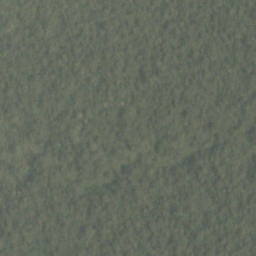

In [9]:
transforms.ToPILImage()(read_image("../data/amazon/train/train_12616.jpg"))

In [10]:
trsfm = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

In [11]:
device = torch.device("mps")
df_train, df_val = train_test_split(df_class, test_size=0.2)

In [12]:
path_train = str(Path(data_dar) / "train")

encoder = MultiLabelBinarizer()
ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
ohe_tags_val = encoder.transform(df_val.list_tags.values)

ds_train = AmazonDataset(df_train, ohe_tags_train, trsfm, path=path_train)
ds_val = AmazonDataset(df_val, ohe_tags_val, trsfm, path=path_train)

dl_train = DataLoader(
    ds_train,
    batch_size=64 * 2,
    shuffle=True,
)
dl_val = DataLoader(
    ds_val,
    batch_size=64,
    shuffle=True,
)

In [13]:
imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 17]))

In [14]:
image, label = imgs[1], labels[1]
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([17]))

In [15]:
label = label.unsqueeze(0).detach().int().cpu().numpy()
label.shape

(1, 17)

In [16]:
encoder.classes_, encoder.classes_.shape

(array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
        'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
        'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
        'selective_logging', 'slash_burn', 'water'], dtype=object),
 (17,))

In [17]:
label.shape

(1, 17)

In [18]:
title = encoder.inverse_transform(label)
title

[('agriculture', 'cultivation', 'haze', 'primary')]

In [19]:
model = models.resnet18(weights=True)
for param in model.parameters():
    param.require_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(128, 17),
    nn.Sigmoid(),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
model = model.to(device)

/Users/vince/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
df_class.tags.values

array(['haze primary', 'agriculture clear primary water', 'clear primary',
       ..., 'agriculture clear primary', 'agriculture clear primary road',
       'agriculture cultivation partly_cloudy primary'], dtype=object)

In [30]:
def train_model(dl_train, dl_val):
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    best_loss_val = np.inf
    epochs = 30
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for data, target in tqdm(dl_train, leave=False):
            data, target = data.to(device, dtype=torch.float), target.to(
                device, dtype=torch.float
            )
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        for data, target in tqdm(dl_val, leave=False):
            data, target = data.to(device, dtype=torch.float), target.to(
                device, dtype=torch.float
            )
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

        train_loss = train_loss / len(dl_train)
        valid_loss = valid_loss / len(dl_val)

        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        if valid_loss <= best_loss_val:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            torch.save(model.state_dict(), "model_cifar.pt")
            valid_loss_min = valid_loss

In [32]:
train_model(dl_train, dl_val)